In [1]:
import time

from data_stream import StreamReceiver

from simulation.webots.controllers.ardupilot_vehicle_controller.drone_data import RangefinderData, CameraData, FDMData, GimbalAxisData, GimbalData, DroneData
from mavlink.mavlink import MAVLinkController, DataAcquisitionThread
from mavlink.mavlink.processor import DataProcessor, GimbalProcessor, GlobalPositionProcessor, AttitudeProcessor

import cv2


mavlink_connection = MAVLinkController("udp:0.0.0.0:14550")

attitude_processor = AttitudeProcessor()
gimbal_processor = GimbalProcessor()

acquisition_thread = DataAcquisitionThread(mavlink_connection, [attitude_processor, gimbal_processor])
acquisition_thread.start()

In [2]:
from data_stream import StreamReceiver

from simulation.webots.controllers.ardupilot_vehicle_controller.drone_data import RangefinderData, CameraData, FDMData, GimbalAxisData, GimbalData, DroneData
import cv2


host = "192.168.0.107"
port = 5588
stream_receiver = StreamReceiver(host, port)

In [18]:
import math


latest_data = gimbal_processor.queue.get_latest()
if latest_data:
    print("GIMBAL", [axis for axis in latest_data.quaternion.to_euler()])


GIMBAL [0.0, -0.2617994102232619, 0.0]


In [17]:
mavlink_connection.gimbal.set_angles(
    roll=0,
    pitch=-15,
    yaw=0
)

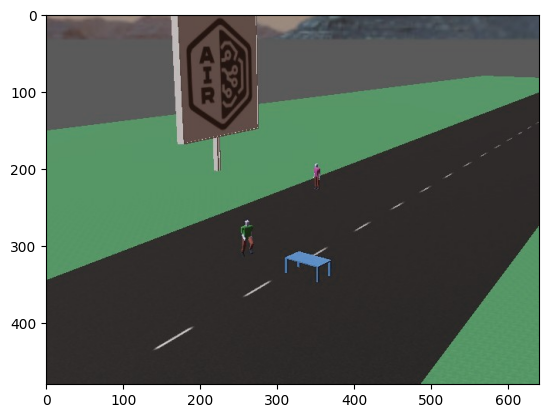

In [8]:
from matplotlib import pyplot as plt


data = stream_receiver.get_data()
drone_data = DroneData.from_json(data)
camera_frame = drone_data.camera.frame

gimbal_status = gimbal_processor.queue.get_latest()

plt.imshow(camera_frame)
plt.show()

In [9]:
from ultralytics import YOLO
import random
from deep_sort.deep_sort.tracker import Tracker
from deep_sort.deep_sort.deep.extractor import Extractor
from deep_sort.deep_sort.deep.configuration import ResNetConfiguration
from deep_sort.deep_sort.deep.weights import RESNET18_WEIGHTS


model = YOLO("yolov8n.pt")

detection_threshold = 0.01

resnet = ResNetConfiguration(
    base="resnet18",
    weights_path=RESNET18_WEIGHTS,
    use_cuda=True
)
extractor = Extractor(model=resnet, batch_size=4)

tracker = Tracker(
    feature_extractor=extractor
)

colors = [(
    random.randint(0, 255),
    random.randint(0, 255),
    random.randint(0, 255)) for j in range(10)
]

Target:
	class_id: 0
	score: 0.7656594514846802
	x1 y1 x2 y1: [251, 265, 270, 312]
Target:
	class_id: 0
	score: 0.48212945461273193
	x1 y1 x2 y1: [346, 193, 356, 229]
Target:
	class_id: 4
	score: 0.4410768747329712
	x1 y1 x2 y1: [398, 268, 422, 283]
Target:
	class_id: 4
	score: 0.38484111428260803
	x1 y1 x2 y1: [445, 242, 465, 255]
Target:
	class_id: 4
	score: 0.28653684258461
	x1 y1 x2 y1: [484, 222, 500, 233]


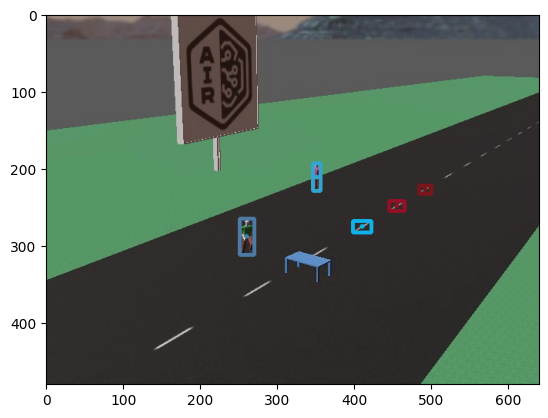

In [10]:
results = model.predict(
    camera_frame,
    verbose=False
)
result = results[0]

print_frame = camera_frame.copy()
detections = []
for i, result in enumerate(result.boxes.data.tolist()):    
    x1, y1, x2, y2, score, class_id = result
    x1 = int(x1)
    x2 = int(x2)
    y1 = int(y1)
    y2 = int(y2)
    class_id = int(class_id)
    
    detections.append([x1, y1, x2, y2, score, class_id])
    
    print(f"Target:\n"
          f"\tclass_id: {class_id}\n"
          f"\tscore: {score}\n"
          f"\tx1 y1 x2 y1: {[x1, y1, x2, y2]}")

    color = colors[i % len(colors)]

    cv2.rectangle(
        print_frame,
        (int(x1), int(y1)),
        (int(x2), int(y2)),
        color,
        3
    )
    
    cx = int((x1 + x2) / 2)
    cy = int((y1 + y2) / 2)
    
    cv2.circle(
        print_frame,
        (cx, cy),
        3,
        color,
        -1
    )
        
plt.imshow(print_frame)
plt.show()

In [11]:
from mavlink.mavlink.data import Gimbal

gimbal_message = mavlink_connection.receive_packet(gimbal_processor.data_type.value)
print(Gimbal.from_mavlink(gimbal_message).quaternion.to_euler())


(0.0, -0.2617994102232619, 0.0)


In [14]:
from math import atan, tan, radians, degrees
import time


fov_vertical = 2 * atan(tan(drone_data.camera.fov * 0.5) * (drone_data.camera.height / drone_data.camera.width))

def find_center(x1, y1, x2, y2):
    center_x = (x1 + x2) // 2
    center_y = (y1 + y2) // 2
    
    return center_x, center_y


for i, detection in enumerate(detections):
    x1, y1, x2, y2, score, class_id = detection
    
    if class_id != 0:
        continue
    
    target_center_x, target_center_y = find_center(x1, y1, x2, y2)
    
    image_center_x, image_center_y = find_center(0, 0, drone_data.camera.width, drone_data.camera.height)
    
    offset_x = target_center_x - image_center_x
    offset_y = target_center_y - image_center_y
    
    offset_x_radians = (offset_x / drone_data.camera.width) * drone_data.camera.fov
    offset_y_radians = (offset_y / drone_data.camera.height) * fov_vertical    
    
    gimbal_message = mavlink_connection.receive_packet(gimbal_processor.data_type.value)
    roll, pitch, yaw = Gimbal.from_mavlink(gimbal_message).quaternion.to_euler()     
    
    print(
        f"ID: {i}\n"
        f"\tGimbal: {roll, pitch, yaw}\n"
        f"\tOffset xy pixels: {[offset_x, offset_y]}\n"
        f"\tOffset xy radians: {[offset_x_radians, offset_y_radians]}\n"
        f"\tDesired: {degrees(pitch - offset_y_radians), degrees(yaw - offset_x_radians)}"
    )
    
mavlink_connection.gimbal.set_angles(
    roll=0,
    pitch=degrees(pitch - offset_y_radians),
    yaw=degrees(yaw + offset_x_radians)
)

ID: 0
	Gimbal: (0.0, -0.2617994102232619, 0.0)
	Offset xy pixels: [26, -29]
	Offset xy radians: [0.031890625000000006, -0.036376672212160316]
	Desired: (-12.915771494319399, -1.8271982185343913)
ID: 1
	Gimbal: (0.0, -0.2617994102232619, 0.0)
	Offset xy pixels: [171, 0]
	Offset xy radians: [0.20974218750000004, 0.0]
	Desired: (-15.000001284807006, -12.017342129591574)


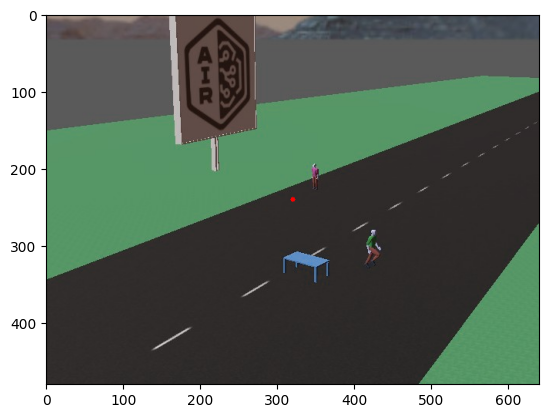

In [12]:
new_data = stream_receiver.get_data()
new_drone_data = DroneData.from_json(new_data)
new_camera_frame = new_drone_data.camera.frame

new_gimbal_status = gimbal_processor.queue.get_latest()

cv2.circle(
    new_camera_frame,
    (int(new_drone_data.camera.width / 2), int(new_drone_data.camera.height / 2)),
    3,
    (255, 0, 0),
    -1
)

plt.imshow(new_camera_frame)
plt.show()

In [19]:
while True:
    data = stream_receiver.get_data()
    drone_data = DroneData.from_json(data)
    camera_frame = drone_data.camera.frame
    
    gimbal_message = mavlink_connection.receive_packet(gimbal_processor.data_type.value)
    roll, pitch, yaw = Gimbal.from_mavlink(gimbal_message).quaternion.to_euler() 
    
    results = model.predict(
        camera_frame,
        verbose=False
    )
    result = results[0]
    
    print_frame = camera_frame.copy()
    detections = []
    for i, result in enumerate(result.boxes.data.tolist()):    
        x1, y1, x2, y2, score, class_id = result
        x1 = int(x1)
        x2 = int(x2)
        y1 = int(y1)
        y2 = int(y2)
        class_id = int(class_id)
        
        detections.append([x1, y1, x2, y2, score, class_id])
            
        color = colors[i % len(colors)]
    
        cv2.rectangle(
            print_frame,
            (int(x1), int(y1)),
            (int(x2), int(y2)),
            color,
            3
        )
        
        cx = int((x1 + x2) / 2)
        cy = int((y1 + y2) / 2)
        
        cv2.circle(
            print_frame,
            (cx, cy),
            3,
            color,
            -1
        )
    
    tracker.update(camera_frame, detections)
    
    gimbal_message = mavlink_connection.receive_packet(gimbal_processor.data_type.value)
    roll, pitch, yaw = Gimbal.from_mavlink(gimbal_message).quaternion.to_euler() 
    
    for track in tracker.tracks:
        x1, y1, x2, y2 = track.to_tlbr()
        track_id = track.track_id
        class_id = track.class_id
    
        if class_id != 0:
            continue
        
        target_center_x, target_center_y = find_center(x1, y1, x2, y2)
        
        image_center_x, image_center_y = find_center(0, 0, drone_data.camera.width, drone_data.camera.height)
        
        offset_x = target_center_x - image_center_x
        offset_y = target_center_y - image_center_y
        
        offset_x_radians = (offset_x / drone_data.camera.width) * drone_data.camera.fov
        offset_y_radians = (offset_y / drone_data.camera.height) * fov_vertical                        
        
        print(
            f"ID: {track_id}\n"
            f"\tGimbal: {roll, pitch, yaw}\n"
            f"\tOffset xy pixels: {[offset_x, offset_y]}\n"
            f"\tOffset xy radians: {[offset_x_radians, offset_y_radians]}\n"
            f"\tDesired: {degrees(pitch - offset_y_radians), degrees(yaw - offset_x_radians)}"
        )
        
        mavlink_connection.gimbal.set_angles(
            roll=0,
            pitch=degrees(pitch - offset_y_radians),
            yaw=degrees(yaw + offset_x_radians)
        )
        
        time.sleep(1)
        
        break
    

ID: 30
	Gimbal: (0.0, -0.2617994102232619, 0.0)
	Offset xy pixels: [-36.0, -39.0]
	Offset xy radians: [-0.04415625, -0.04892035228531905]
	Desired: (-12.197071566565052, 2.5299667641245414)
ID: 2
	Gimbal: (0.0, -0.2617994102232619, 0.0)
	Offset xy pixels: [-49.0, 13.0]
	Offset xy radians: [-0.060101562500000004, 0.01630678409510635]
	Desired: (-15.934311190887655, 3.443565873391737)
ID: 2
	Gimbal: (0.0, -0.2617994102232619, 0.0)
	Offset xy pixels: [-51.0, 14.0]
	Offset xy radians: [-0.0625546875, 0.017561152102422223]
	Desired: (-16.00618118366309, 3.584119582509767)
ID: 17
	Gimbal: (0.0, -0.2617994102232619, 0.0)
	Offset xy pixels: [63.0, -43.0]
	Offset xy radians: [0.0772734375, -0.05393782431458254]
	Desired: (-11.909591595463313, -4.427441837217947)
ID: 2
	Gimbal: (0.0, -0.2617994102232619, 0.0)
	Offset xy pixels: [-44.0, 12.0]
	Offset xy radians: [-0.05396875000000001, 0.015052416087790477]
	Desired: (-15.86244119811222, 3.0921816005966622)
ID: 2
	Gimbal: (0.0, -0.2617994102232619

KeyboardInterrupt: 